# 00.Importing Libraries

In [124]:
#!pip install --quiet prophet
#!pip install --quiet plotly

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import sqrt
from prophet import Prophet
import plotly.express as px
from prophet.plot import plot_plotly
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_error

# 01.Helpers

## Constants

## 01.02 Functions

In [126]:
def train_test_split(df, test_date, target_variable):
    # separação por tempo
    df_train = df[df.index < test_date]
    df_test  = df[df.index >= test_date]

    # remoção da variável target
    y_train = df_train[target_variable]
    y_test  = df_test[target_variable]

    df_train = df_train.drop(columns=target_variable).copy()
    df_test  = df_test.drop(columns=target_variable).copy()

    print(df_train.shape, y_train.shape)
    print(df_test.shape, y_test.shape)

    return df_train, df_test, y_train, y_test

In [127]:
def data_normalization(df_train, df_test, y_train, y_test):
    # Para as features
    scaler               = MinMaxScaler(feature_range=(0, 1))
    df_train_scaled      = scaler.fit_transform(df_train)
    df_test_scaled       = scaler.transform(df_test)

    # Para a variável alvo
    scaler_target       = MinMaxScaler(feature_range=(0, 1))
    y_train_scaled      = scaler_target.fit_transform(y_train.to_frame())
    y_test_scaled       = scaler_target.transform(y_test.to_frame())

    print(df_train_scaled.shape, y_train_scaled.shape)
    print(df_test_scaled.shape, y_test_scaled.shape)

    return scaler, scaler_target, df_train_scaled, df_test_scaled, y_train_scaled, y_test_scaled

In [128]:
def data_reconversion(scaler, scaler_target, df_train_scaled, df_test_scaled, y_train_scaled, y_test_scaled, y_pred):
    df_train_original = scaler.inverse_transform(df_train_scaled)
    df_test_original = scaler.inverse_transform(df_test_scaled)

    y_train_original = scaler_target.inverse_transform(y_train_scaled)
    y_test_original = scaler_target.inverse_transform(y_test_scaled)
    y_pred_original = scaler_target.inverse_transform(y_pred)

    return df_train_original, df_test_original, y_train_original, y_test_original, y_pred_original

In [129]:
def metrics(y, predicted):
    mae = mean_absolute_error(y, predicted)
    mse = mean_squared_error(y, predicted)
    rmse = mean_squared_error(y, predicted)
    mape = np.mean(np.abs((y - predicted) / y)) * 100
    r2 = r2_score(y, predicted)
    return mae, mse, rmse, mape, r2

def print_metrics(y, predicted):
    mae, mse, rmse, mape, r2 = metrics(y, predicted)
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"R-Squared (R²): {r2:.2f}")

# 02.Importing Dataset

In [130]:
dataset = pd.read_csv('../../Preprocessing/dataset.csv', 
                   header=0, 
                   index_col=0)

dataset

,hospitalizations,hospitalizations_lag_3,average_stay_lag_3,deaths_lag_3,mortality_rate_lag_3,hospitalizations_lag_3_12m_window,average_stay_lag_3_12m_window,deaths_lag_3_12m_window,mortality_rate_lag_3_12m_window,heat_index,...,heat_index99,heat_index95,temperature_mean,temperature_max,temperature_min,wind_speed_mean,humidity_mean,lag_heat_index_1,lag_heat_index_2,lag_heat_index_3
date,,,,,,,,,,,,,,,,,,,,,
2000-12-01,4266.0,4365.0,6.4,293.0,6.71,4277.500000,5.900000,245.333333,5.728333,24.154261,...,37.8966,33.5380,23.575000,35.4,13.4,1.826613,70.836022,21.132403,19.318992,15.300694
2001-01-01,4032.0,4388.0,6.3,275.0,6.27,4257.250000,5.925000,246.250000,5.775833,26.316156,...,37.8471,34.6685,25.136962,35.4,17.0,1.777016,75.375000,24.154261,21.132403,19.318992
2001-02-01,3888.0,4329.0,6.1,258.0,5.96,4256.583333,5.933333,248.083333,5.819167,27.119464,...,37.7548,35.3940,25.691071,34.2,20.2,1.916518,76.424107,26.316156,24.154261,21.132403
2001-03-01,3658.0,4266.0,6.1,242.0,5.67,4265.166667,5.966667,250.833333,5.873333,26.113387,...,36.7670,34.4155,24.985349,34.4,16.3,1.629704,76.383065,27.119464,26.316156,24.154261
2001-04-01,4022.0,4032.0,5.9,218.0,5.41,4263.833333,5.975000,250.666667,5.871667,21.383903,...,31.0030,28.0215,21.038333,30.8,11.9,1.455139,81.152778,26.113387,27.119464,26.316156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01,3172.0,3176.0,6.4,264.0,8.31,3490.333333,6.950000,316.416667,9.045833,16.708185,...,33.1822,27.3330,16.684946,32.5,7.1,1.345027,85.837366,22.136556,25.621075,27.636221
2024-06-01,3640.0,3390.0,6.7,277.0,8.17,3503.083333,6.916667,316.500000,9.015833,17.283889,...,29.7834,26.8025,17.371111,31.5,4.6,1.265139,80.636111,16.708185,22.136556,25.621075
2024-07-01,3689.0,3329.0,6.5,308.0,9.25,3510.166667,6.891667,321.500000,9.150000,13.313495,...,26.8167,21.7780,13.736022,28.9,3.4,1.123387,81.887097,17.283889,16.708185,22.136556


In [131]:
dataset.index = pd.to_datetime(dataset.index)

dataset.head(5)

,hospitalizations,hospitalizations_lag_3,average_stay_lag_3,deaths_lag_3,mortality_rate_lag_3,hospitalizations_lag_3_12m_window,average_stay_lag_3_12m_window,deaths_lag_3_12m_window,mortality_rate_lag_3_12m_window,heat_index,...,heat_index99,heat_index95,temperature_mean,temperature_max,temperature_min,wind_speed_mean,humidity_mean,lag_heat_index_1,lag_heat_index_2,lag_heat_index_3
date,,,,,,,,,,,,,,,,,,,,,
2000-12-01,4266.0,4365.0,6.4,293.0,6.71,4277.500000,5.900000,245.333333,5.728333,24.154261,...,37.8966,33.5380,23.575000,35.4,13.4,1.826613,70.836022,21.132403,19.318992,15.300694
2001-01-01,4032.0,4388.0,6.3,275.0,6.27,4257.250000,5.925000,246.250000,5.775833,26.316156,...,37.8471,34.6685,25.136962,35.4,17.0,1.777016,75.375000,24.154261,21.132403,19.318992
2001-02-01,3888.0,4329.0,6.1,258.0,5.96,4256.583333,5.933333,248.083333,5.819167,27.119464,...,37.7548,35.3940,25.691071,34.2,20.2,1.916518,76.424107,26.316156,24.154261,21.132403
2001-03-01,3658.0,4266.0,6.1,242.0,5.67,4265.166667,5.966667,250.833333,5.873333,26.113387,...,36.7670,34.4155,24.985349,34.4,16.3,1.629704,76.383065,27.119464,26.316156,24.154261
2001-04-01,4022.0,4032.0,5.9,218.0,5.41,4263.833333,5.975000,250.666667,5.871667,21.383903,...,31.0030,28.0215,21.038333,30.8,11.9,1.455139,81.152778,26.113387,27.119464,26.316156


In [132]:
dataset.columns

Index(['hospitalizations', 'hospitalizations_lag_3', 'average_stay_lag_3',
       'deaths_lag_3', 'mortality_rate_lag_3',
       'hospitalizations_lag_3_12m_window', 'average_stay_lag_3_12m_window',
       'deaths_lag_3_12m_window', 'mortality_rate_lag_3_12m_window',
       'heat_index', 'heat_index_sum', 'heat_index_std', 'heat_index99',
       'heat_index95', 'temperature_mean', 'temperature_max',
       'temperature_min', 'wind_speed_mean', 'humidity_mean',
       'lag_heat_index_1', 'lag_heat_index_2', 'lag_heat_index_3'],
      dtype='object')

# 03.Preprocessing

## 03.01 Remoção ano 2000

In [133]:
dataset = dataset[dataset.index < "2020-01-01"]

test_start_date = '2017-01-01'

# 04.Model training

## 04.01 Split train and test

In [134]:
df_train, df_test, y_train, y_test = train_test_split(dataset, test_start_date, 'hospitalizations')

(193, 21) (193,)
(36, 21) (36,)


## 04.02 Normalization

In [135]:
scaler, scaler_target, df_train_scaled, df_test_scaled, y_train_scaled, y_test_scaled = data_normalization(df_train, df_test, y_train, y_test)

(193, 21) (193, 1)
(36, 21) (36, 1)


## 04.03 Prophet

In [136]:
df_train

,hospitalizations_lag_3,average_stay_lag_3,deaths_lag_3,mortality_rate_lag_3,hospitalizations_lag_3_12m_window,average_stay_lag_3_12m_window,deaths_lag_3_12m_window,mortality_rate_lag_3_12m_window,heat_index,heat_index_sum,...,heat_index99,heat_index95,temperature_mean,temperature_max,temperature_min,wind_speed_mean,humidity_mean,lag_heat_index_1,lag_heat_index_2,lag_heat_index_3
date,,,,,,,,,,,,,,,,,,,,,
2000-12-01,4365.0,6.4,293.0,6.71,4277.500000,5.900000,245.333333,5.728333,24.154261,17970.77,...,37.8966,33.5380,23.575000,35.4,13.4,1.826613,70.836022,21.132403,19.318992,15.300694
2001-01-01,4388.0,6.3,275.0,6.27,4257.250000,5.925000,246.250000,5.775833,26.316156,19579.22,...,37.8471,34.6685,25.136962,35.4,17.0,1.777016,75.375000,24.154261,21.132403,19.318992
2001-02-01,4329.0,6.1,258.0,5.96,4256.583333,5.933333,248.083333,5.819167,27.119464,18224.28,...,37.7548,35.3940,25.691071,34.2,20.2,1.916518,76.424107,26.316156,24.154261,21.132403
2001-03-01,4266.0,6.1,242.0,5.67,4265.166667,5.966667,250.833333,5.873333,26.113387,19428.36,...,36.7670,34.4155,24.985349,34.4,16.3,1.629704,76.383065,27.119464,26.316156,24.154261
2001-04-01,4032.0,5.9,218.0,5.41,4263.833333,5.975000,250.666667,5.871667,21.383903,15396.41,...,31.0030,28.0215,21.038333,30.8,11.9,1.455139,81.152778,26.113387,27.119464,26.316156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08-01,3235.0,6.2,279.0,8.62,3379.250000,6.316667,298.500000,8.810000,16.035712,11930.57,...,31.7783,24.6685,16.246505,32.3,6.6,1.170565,80.104839,13.902984,11.039000,14.905067
2016-09-01,3267.0,6.4,353.0,10.81,3364.416667,6.300000,301.500000,8.944167,16.023625,11537.01,...,27.6624,23.7620,16.277917,31.2,8.8,1.671528,78.400000,16.035712,13.902984,11.039000
2016-10-01,3459.0,6.6,351.0,10.15,3359.500000,6.325000,300.083333,8.918333,19.317137,14371.95,...,30.3068,27.0685,19.240323,32.3,9.5,1.860484,78.583333,16.023625,16.035712,13.902984


In [137]:
df = pd.DataFrame({
        'ds': df_train.index,
        'y': y_train_scaled.reshape(-1),
        'hospitalizations_lag_3': df_train_scaled[:, 0],
        'average_stay_lag_3': df_train_scaled[:, 1],
        'deaths_lag_3': df_train_scaled[:, 2],
        'mortality_rate_lag_3': df_train_scaled[:, 3],
        'hospitalizations_lag_3_12m_window': df_train_scaled[:, 4],
        'average_stay_lag_3_12m_window': df_train_scaled[:, 5],
        'deaths_lag_3_12m_window': df_train_scaled[:, 6],
        'mortality_rate_lag_3_12m_window': df_train_scaled[:, 7],
        'heat_index': df_train_scaled[:, 8],
        'heat_index_sum': df_train_scaled[:, 9],
        'heat_index_std': df_train_scaled[:, 10], 
        'heat_index99': df_train_scaled[:, 11], 
        'heat_index95': df_train_scaled[:, 12], 
        'temperature_mean': df_train_scaled[:, 13],
        'temperature_max': df_train_scaled[:, 14], 
        'temperature_min': df_train_scaled[:, 15], 
        'wind_speed_mean': df_train_scaled[:, 16],
        'humidity_mean': df_train_scaled[:, 17], 
        'lag_heat_index_1': df_train_scaled[:, 18], 
        'lag_heat_index_2': df_train_scaled[:, 19],
        'lag_heat_index_3': df_train_scaled[:, 20],
    })

df

,ds,y,hospitalizations_lag_3,average_stay_lag_3,deaths_lag_3,mortality_rate_lag_3,hospitalizations_lag_3_12m_window,average_stay_lag_3_12m_window,deaths_lag_3_12m_window,mortality_rate_lag_3_12m_window,...,heat_index99,heat_index95,temperature_mean,temperature_max,temperature_min,wind_speed_mean,humidity_mean,lag_heat_index_1,lag_heat_index_2,lag_heat_index_3
0,2000-12-01,0.760952,0.808095,0.666667,0.524138,0.3040,1.000000,0.000000,0.000000,0.000000,...,0.769188,0.694720,0.803586,0.740541,0.643564,0.649677,0.271381,0.592743,0.486249,0.250271
1,2001-01-01,0.649524,0.819048,0.600000,0.462069,0.2336,0.980330,0.044776,0.012821,0.014271,...,0.767183,0.740995,0.908859,0.740541,0.821782,0.614071,0.470696,0.770204,0.592743,0.486249
2,2001-02-01,0.580952,0.790952,0.466667,0.403448,0.1840,0.979683,0.059701,0.038462,0.027291,...,0.763444,0.770692,0.946205,0.675676,0.980198,0.714222,0.516764,0.897163,0.770204,0.592743
3,2001-03-01,0.471429,0.760952,0.466667,0.348276,0.1376,0.988020,0.119403,0.076923,0.043565,...,0.723434,0.730639,0.898641,0.686486,0.787129,0.508313,0.514962,0.944338,0.897163,0.770204
4,2001-04-01,0.644762,0.649524,0.333333,0.265517,0.0960,0.986725,0.134328,0.074592,0.043065,...,0.489969,0.468911,0.632621,0.491892,0.569307,0.382989,0.724409,0.885255,0.944338,0.897163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,2016-08-01,0.402857,0.270000,0.533333,0.475862,0.6096,0.127489,0.746269,0.743590,0.925889,...,0.521372,0.331662,0.309663,0.572973,0.306931,0.178688,0.678392,0.168190,0.000000,0.227038
189,2016-09-01,0.350000,0.285238,0.666667,0.731034,0.9600,0.113081,0.716418,0.785548,0.966199,...,0.354661,0.294556,0.311780,0.513514,0.415842,0.538339,0.603529,0.293436,0.168190,0.000000
190,2016-10-01,0.505238,0.376667,0.800000,0.724138,0.8544,0.108305,0.761194,0.765734,0.958438,...,0.461770,0.429902,0.511439,0.572973,0.450495,0.673994,0.611580,0.292726,0.293436,0.168190
191,2016-11-01,0.395238,0.402857,0.800000,0.693103,0.7872,0.096649,0.791045,0.755245,0.961693,...,0.632118,0.557675,0.623316,0.702703,0.470297,0.435537,0.368357,0.486140,0.292726,0.293436


## Training

In [138]:
model = Prophet()

# Add exogenous variables as regressors
model.add_regressor('hospitalizations_lag_3')
model.add_regressor('average_stay_lag_3')
model.add_regressor('deaths_lag_3')
model.add_regressor('mortality_rate_lag_3')
model.add_regressor('hospitalizations_lag_3_12m_window')
model.add_regressor('average_stay_lag_3_12m_window')
model.add_regressor('deaths_lag_3_12m_window')
model.add_regressor('mortality_rate_lag_3_12m_window')
model.add_regressor('heat_index')
model.add_regressor('heat_index_sum')
model.add_regressor('heat_index_std')
model.add_regressor('heat_index99')
model.add_regressor('heat_index95')
model.add_regressor('temperature_mean')
model.add_regressor('temperature_max')
model.add_regressor('temperature_min')
model.add_regressor('wind_speed_mean')
model.add_regressor('humidity_mean')
model.add_regressor('lag_heat_index_1')
model.add_regressor('lag_heat_index_2')
model.add_regressor('lag_heat_index_3')

model.fit(df)

03:10:25 - cmdstanpy - INFO - Chain [1] start processing
03:10:25 - cmdstanpy - INFO - Chain [1] done processing


### Forecasting

In [139]:
df_test_scaled[:, 0]

array([0.5052381 , 0.3952381 , 0.24238095, 0.26809524, 0.09      ,
       0.26952381, 0.19904762, 0.41142857, 0.35238095, 0.37761905,
       0.37428571, 0.44190476, 0.31428571, 0.36047619, 0.29238095,
       0.2747619 , 0.10761905, 0.19761905, 0.1852381 , 0.21619048,
       0.2947619 , 0.33238095, 0.32619048, 0.34428571, 0.3252381 ,
       0.21333333, 0.21904762, 0.20571429, 0.20761905, 0.0947619 ,
       0.26857143, 0.25761905, 0.27190476, 0.33666667, 0.44857143,
       0.4047619 ])

In [140]:
future = model.make_future_dataframe(periods=len(df_test_scaled), freq='ME')

# Add exogenous variables as regressors
future['hospitalizations_lag_3'] = np.concatenate((df_train_scaled[:, 0], df_test_scaled[:, 0]))
future['average_stay_lag_3'] = np.concatenate((df_train_scaled[:, 1], df_test_scaled[:, 1]))
future['deaths_lag_3'] = np.concatenate((df_train_scaled[:, 2], df_test_scaled[:, 2]))
future['mortality_rate_lag_3'] = np.concatenate((df_train_scaled[:, 3], df_test_scaled[:, 3]))
future['hospitalizations_lag_3_12m_window'] = np.concatenate((df_train_scaled[:, 4], df_test_scaled[:, 4]))
future['average_stay_lag_3_12m_window'] = np.concatenate((df_train_scaled[:, 5], df_test_scaled[:, 5]))
future['deaths_lag_3_12m_window'] = np.concatenate((df_train_scaled[:, 6], df_test_scaled[:, 6]))
future['mortality_rate_lag_3_12m_window'] = np.concatenate((df_train_scaled[:, 7], df_test_scaled[:, 7]))
future['heat_index'] = np.concatenate((df_train_scaled[:, 8], df_test_scaled[:, 8]))
future['heat_index_sum'] = np.concatenate((df_train_scaled[:, 9], df_test_scaled[:, 9]))
future['heat_index_std'] = np.concatenate((df_train_scaled[:, 10], df_test_scaled[:, 10]))
future['heat_index99'] = np.concatenate((df_train_scaled[:, 11], df_test_scaled[:, 11]))
future['heat_index95'] = np.concatenate((df_train_scaled[:, 12], df_test_scaled[:, 12]))
future['temperature_mean'] = np.concatenate((df_train_scaled[:, 13], df_test_scaled[:, 13]))
future['temperature_max'] = np.concatenate((df_train_scaled[:, 14], df_test_scaled[:, 14]))
future['temperature_min'] = np.concatenate((df_train_scaled[:, 15], df_test_scaled[:, 15]))
future['wind_speed_mean'] = np.concatenate((df_train_scaled[:, 16], df_test_scaled[:, 16]))
future['humidity_mean'] = np.concatenate((df_train_scaled[:, 17], df_test_scaled[:, 17]))
future['lag_heat_index_1'] = np.concatenate((df_train_scaled[:, 18], df_test_scaled[:, 18]))
future['lag_heat_index_2'] = np.concatenate((df_train_scaled[:, 19], df_test_scaled[:, 19]))
future['lag_heat_index_3'] = np.concatenate((df_train_scaled[:, 20], df_test_scaled[:, 20]))

# Generate forecasts
y_pred = model.predict(future)

In [141]:
y_pred = model.predict(future)

y_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,average_stay_lag_3,...,wind_speed_mean,wind_speed_mean_lower,wind_speed_mean_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-12-01,0.617606,0.643873,0.845298,0.617606,0.617606,0.124860,0.124860,0.124860,0.006059,...,-0.006214,-0.006214,-0.006214,-0.045235,-0.045235,-0.045235,0.0,0.0,0.0,0.742466
1,2001-01-01,0.616112,0.609814,0.812421,0.616112,0.616112,0.099459,0.099459,0.099459,0.003597,...,-0.005061,-0.005061,-0.005061,-0.020341,-0.020341,-0.020341,0.0,0.0,0.0,0.715571
2,2001-02-01,0.614617,0.483589,0.684560,0.614617,0.614617,-0.033920,-0.033920,-0.033920,-0.001327,...,-0.008304,-0.008304,-0.008304,-0.029299,-0.029299,-0.029299,0.0,0.0,0.0,0.580698
3,2001-03-01,0.613268,0.580764,0.789174,0.613268,0.613268,0.072570,0.072570,0.072570,-0.001327,...,-0.001636,-0.001636,-0.001636,-0.007251,-0.007251,-0.007251,0.0,0.0,0.0,0.685838
4,2001-04-01,0.611774,0.598753,0.805832,0.611774,0.611774,0.096423,0.096423,0.096423,-0.006250,...,0.002422,0.002422,0.002422,-0.030465,-0.030465,-0.030465,0.0,0.0,0.0,0.708197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,2019-07-31,0.301897,0.273469,0.483289,0.301568,0.302230,0.080392,0.080392,0.080392,-0.001327,...,0.003451,0.003451,0.003451,0.010724,0.010724,0.010724,0.0,0.0,0.0,0.382289
225,2019-08-31,0.300530,0.230930,0.436731,0.300187,0.300876,0.035477,0.035477,0.035477,0.006059,...,0.002471,0.002471,0.002471,-0.006205,-0.006205,-0.006205,0.0,0.0,0.0,0.336006
226,2019-09-30,0.299207,0.169498,0.378454,0.298852,0.299561,-0.023520,-0.023520,-0.023520,0.006059,...,-0.001986,-0.001986,-0.001986,-0.073876,-0.073876,-0.073876,0.0,0.0,0.0,0.275687
227,2019-10-31,0.297840,0.312448,0.522196,0.297468,0.298209,0.113532,0.113532,0.113532,0.006059,...,-0.000539,-0.000539,-0.000539,0.103542,0.103542,0.103542,0.0,0.0,0.0,0.411372


In [142]:
print(y_pred[['ds', 'yhat', 'hospitalizations_lag_3', 'average_stay_lag_3']])

            ds      yhat  hospitalizations_lag_3  average_stay_lag_3
0   2000-12-01  0.742466               -0.253143            0.006059
1   2001-01-01  0.715571               -0.261392            0.003597
2   2001-02-01  0.580698               -0.240232           -0.001327
3   2001-03-01  0.685838               -0.217637           -0.001327
4   2001-04-01  0.708197               -0.133711           -0.006250
..         ...       ...                     ...                 ...
224 2019-07-31  0.382289                0.161462           -0.001327
225 2019-08-31  0.336006                0.150702            0.006059
226 2019-09-30  0.275687                0.101925            0.006059
227 2019-10-31  0.411372                0.017641            0.006059
228 2019-11-30  0.285869                0.050637            0.008520

[229 rows x 4 columns]


**Metrics using test and train**

In [143]:
(
    df_train_original,
    df_test_original,
    y_train_original,
    y_test_original,
    y_pred_original
) = data_reconversion(
    scaler,
    scaler_target,
    df_train_scaled,
    df_test_scaled,
    y_train_scaled,
    y_test_scaled,
    y_pred['yhat'].values.reshape(-1, 1)
)

In [144]:
print_metrics(dataset['hospitalizations'].values.reshape(-1, 1), y_pred_original)

Mean Absolute Error (MAE): 135.23
Mean Squared Error (MSE): 30898.55
Root Mean Squared Error (RMSE): 30898.55
Mean Absolute Percentage Error (MAPE): 3.83%
R-Squared (R²): 0.79


**Metrics using only test**

In [145]:
(
    df_train_original,
    df_test_original,
    y_train_original,
    y_test_original,
    y_pred_original
) = data_reconversion(
    scaler,
    scaler_target,
    df_train_scaled,
    df_test_scaled,
    y_train_scaled,
    y_test_scaled,
    y_pred.tail(len(df_test_scaled))['yhat'].values.reshape(-1, 1)
)

In [146]:
print_metrics(y_test_original, y_pred_original)

Mean Absolute Error (MAE): 160.43
Mean Squared Error (MSE): 38691.59
Root Mean Squared Error (RMSE): 38691.59
Mean Absolute Percentage Error (MAPE): 4.95%
R-Squared (R²): 0.02


In [147]:
px.line(y_pred, x='ds', y='yhat')
# fig = px.line(y_pred, x='ds', y='yhat', title='Previsões do Prophet')
# fig.show()

/home/thiery/.local/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/thiery/.local/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



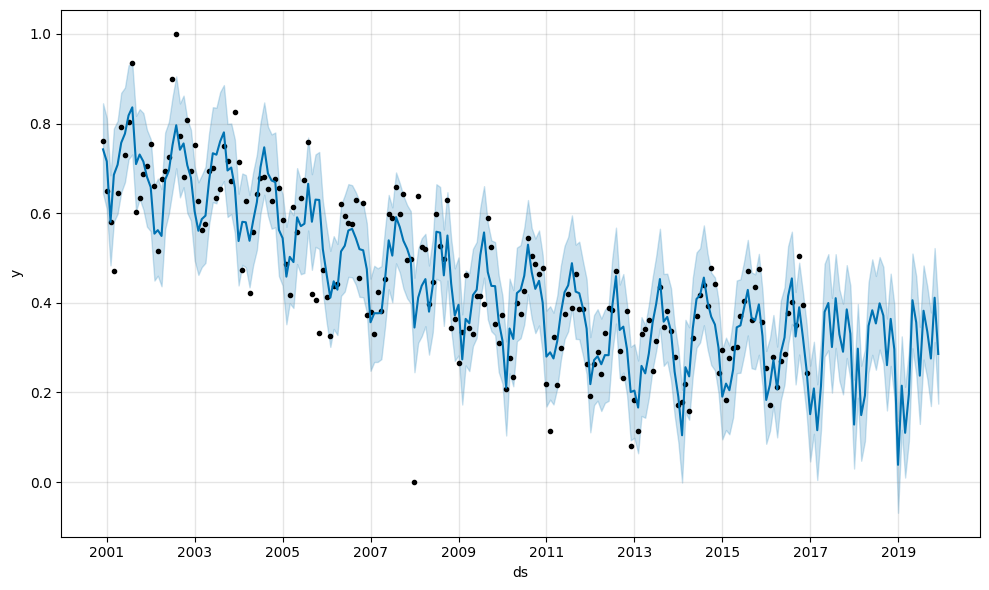

In [148]:
figure = model.plot(y_pred, xlabel='ds', ylabel='y')

/home/thiery/.local/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/thiery/.local/lib/python3.10/site-packages/prophet/plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/thiery/.local/lib/python3.10/site-packages/prophet/plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/thiery/.local/lib/python3.10/site-packages/prophet/plot

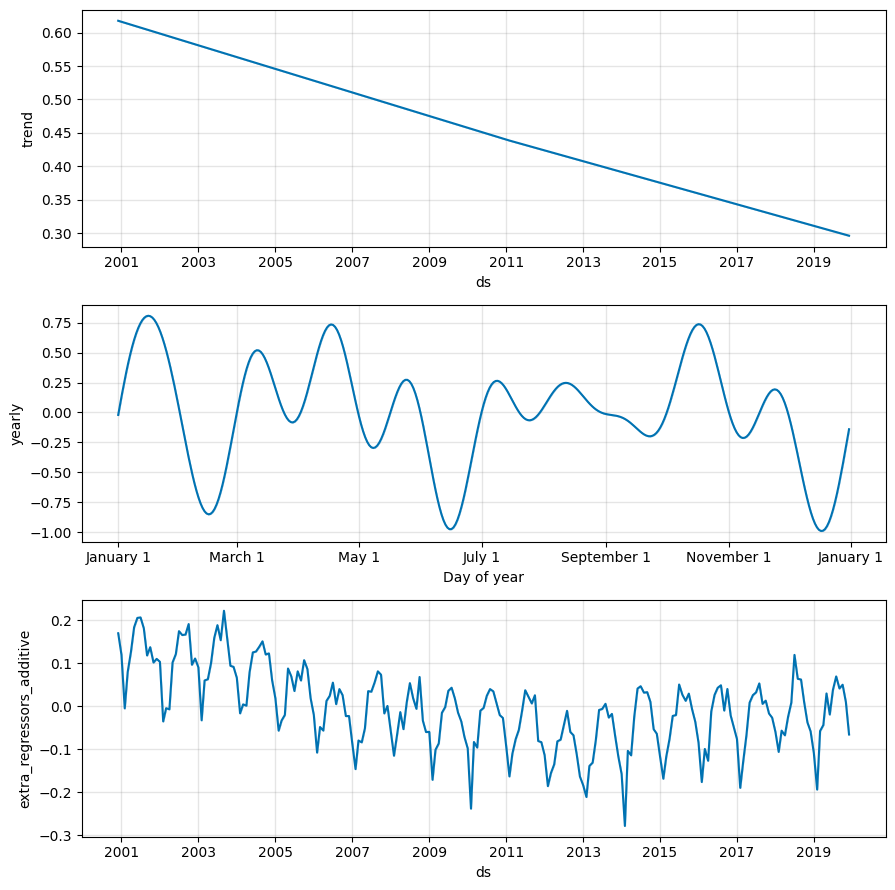

In [149]:
figure2 = model.plot_components(y_pred)

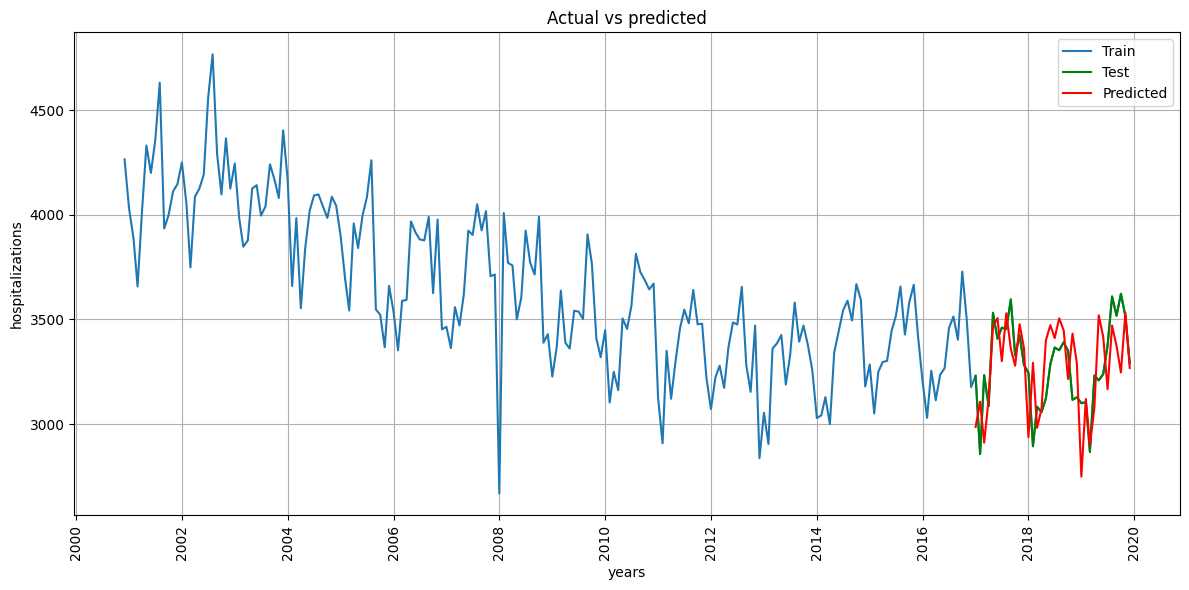

In [150]:
index = dataset[(dataset.index < test_start_date)].index
index_test = dataset[(dataset.index >= test_start_date)].index

plt.figure(figsize=(12, 6))
plt.plot(dataset.index, dataset['hospitalizations'], label='Train')
plt.plot(index_test, y_test_original, color='green', label='Test')
plt.plot(index_test, y_pred_original, color='red', label='Predicted')
plt.title("Actual vs predicted")
plt.xlabel('years')
plt.ylabel('hospitalizations')
plt.grid(True)
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Download the forecast data

In [151]:
y_pred.to_csv('forecast.csv')